In [6]:
# Загружаем картинки
from os import listdir, walk
from os.path import isfile, join
def take_all_pictures_names(path):
    paths = []
    targets = []
    for x in walk(path):
        for y in x[2]:
            if (y.find('depth') == -1):
                paths.append(x[0] + '/' + y)
                targets.append(x[0][len(x[0]) - 1:])
    return paths, targets

def get_all_pictures(path, a, b):
    X = []
    y = []
    names, targets = take_all_pictures_names(path)
    for ind, (name, target) in enumerate(zip(names, targets)):
        if (ind >= a and ind < b):
            X.append(plt.imread(name))
            y.append(target)
    return X, y

def get_pictures_in_range(path, ind_range):
    X = []
    y = []
    names, targets = take_all_pictures_names(path)
    count = 0
    print('all_pictures on disk:', len(names))
    for i in ind_range:
        X.append(plt.imread(names[i]))
        y.append(targets[i])
        count += 1
        if (count % 500 == 0):
            print(count)
    return X, y

def get_need_pictures_in_range(path, ind_range, need_list):
    X = []
    y = []
    names, targets = take_all_pictures_names(path)
    count = 0
    print('all_pictures on disk:', len(names))
    for i in ind_range:
        if (targets[i] in need_list):
            X.append(plt.imread(names[i]))
            y.append(targets[i])
            count += 1
            if (count % 500 == 0):
                print(count)
    return X, y

#Показать картинку
def show_picture(number):
    print(y[number], X[number].shape)
    plt.imshow(X[number])
    
# Меняем размер картинки
from skimage.transform import resize
def resize_picture(img, shape):
    return resize(img, shape, mode='constant')

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.datasets import mnist
%matplotlib inline

## Загружаем данные

In [9]:
# Так можно загружать даннные в X, y
%time X, y = get_need_pictures_in_range('/media/ilya/DATA/sign_recognition_data/dataset5/', range(1, 40000, 3), ['a', 'b', 'c', 'v'])

all_pictures on disk: 65774
500
1000
1500
2000
CPU times: user 14 s, sys: 1.21 s, total: 15.2 s
Wall time: 1min 47s


In [10]:
print(len(X))

2296


In [11]:
# Довольно оптимистичный тест, потому что кадры очень близки, теперь нет
%time X_test, y_test = get_need_pictures_in_range('/media/ilya/DATA/sign_recognition_data/dataset5/', range(40000, 60000, 10), ['a', 'b', 'c', 'v'])

all_pictures on disk: 65774
CPU times: user 1.98 s, sys: 140 ms, total: 2.12 s
Wall time: 20.6 s


In [58]:
size = 60

In [16]:
X_test = np.array([resize_picture(x, (size, size, 3)) for x in X_test])
X = [resize_picture(x, (size, size, 3)) for x in X]

In [17]:
X_p_test = X_test.reshape(len(X_test), size * size * 3)
X = np.array(X)
y = np.array(y)
X_p = X.reshape(len(X), size * size * 3)

b (60, 60, 3)


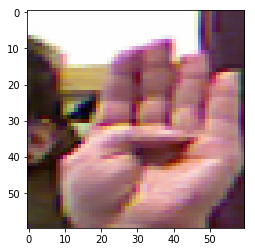

In [18]:
show_picture(900)

In [22]:
np.unique(y_test)

array(['a', 'b', 'c', 'v'], 
      dtype='<U1')

## Ещё данные

In [23]:
def filter_other_data(X, Y):
    X_filter, y_filter = [], []
    for x, y in zip(X, Y):
        y_lower = y.lower()
        if (y_lower in ['a', 'b', 'c', 'v']):
            X_filter.append(x)
            y_filter.append(y_lower)
    return X_filter, y_filter

all_pictures on disk: 4873
500
CPU times: user 376 ms, sys: 12 ms, total: 388 ms
Wall time: 391 ms
['A' 'B' 'C' 'V' 'e' 't']
c
(565, 10800) 565 ['a' 'b' 'c' 'v']


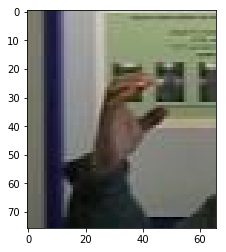

In [26]:
%time X_other, y_other = get_pictures_in_range('../Training/', range(1, 4800, 5))
print(np.unique(y_other))

X_filter_other, y_filter_other = filter_other_data(X_other, y_other)
X_other = X_filter_other
y_other = y_filter_other

print(y_filter_other[300])
plt.imshow(X_filter_other[300])

X_other = np.array([resize_picture(x, (size, size, 3)) for x in X_other])
X_other_p = X_other.reshape((len(X_other), size * size * 3))
print(X_other_p.shape, len(y_other), np.unique(y_other))

### Здесь будет предобработка данных

In [43]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

In [45]:
tsne_model = TSNE(random_state=321)
%time tsne_representation = tsne_model.fit_transform(X_p) 

CPU times: user 1min 42s, sys: 328 ms, total: 1min 43s
Wall time: 1min 42s


In [49]:
y = np.array(y)

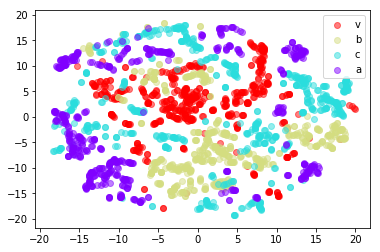

In [50]:
colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for y_o, c in zip(reversed(list(set(y))), reversed(colors)):
    plt.scatter(tsne_representation[y==y_o, 0], 
                tsne_representation[y==y_o, 1], c=c, alpha=0.5, label=str(y_o))
plt.legend()
plt.show()

# PCA and SVM

In [29]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

def fit_pca(X, n_comp):
    pca = PCA(n_components=n_comp)
    return pca.fit(X)

def fit_svm(X, y, C, gamma):
    svm = SVC(C = C, random_state=241, gamma=gamma)
    return svm.fit(X, y)

def fit_pca_svm(X, y, n_comp=100, C = 2, gamma=0.0001):
    pca = fit_pca(X, n_comp=n_comp)
    smv = fit_svm(pca.transform(X), y, C = C, gamma=gamma)
    return (pca, svm)

def fit_get_score_pca_svm(X, y, X_test, y_test, n_comp, C, gamma):
    pca = fit_pca(X, n_comp=n_comp)
    X_tr = pca.transform(X)
    X_test_tr = pca.transform(X_test)
    print(pca.explained_variance_ratio_[:min(n_comp, 20)])
    
    svm = fit_svm(X_tr, y, C = C, gamma = gamma)
    print(svm)
    print('support vectors count:', len(svm.support_))
    print('train score:', accuracy_score(y, svm.predict(X_tr)))
    print('test score:', accuracy_score(y_test, svm.predict(X_test_tr)))
    
    return (pca, svm)

def get_score_pca_svm(pca, svm, X, y):
    X_tr = pca.transform(X)
    y_pred = svm.predict(X_tr)
    return accuracy_score(y, y_pred)

In [34]:
%time pca1, svm1 = fit_get_score_pca_svm(X_p, y, X_p_test, y_test, n_comp=500, C = 2, gamma=0.0001)

print('other dataset:', get_score_pca_svm(pca1, svm1, X_other_p, y_other))

[ 0.27866043  0.08223624  0.05403049  0.03565851  0.03417007  0.02894384
  0.02601918  0.02309145  0.01969167  0.01841626  0.01717035  0.01445706
  0.01310906  0.01197543  0.008859    0.0082484   0.00793396  0.00734715
  0.00721815  0.00630312]
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=241, shrinking=True,
  tol=0.001, verbose=False)
support vectors count: 1424
train score: 0.936846689895
test score: 0.693150684932
CPU times: user 16.7 s, sys: 104 ms, total: 16.8 s
Wall time: 10.9 s
other dataset: 0.364601769912


In [229]:
y_other

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a

In [227]:
im_ilya_a = plt.imread('111.jpg')
im_ilya_a_resize = resize_picture(im_ilya_a, (size, size, 3))
ilya_trans = pca1.transform(im_ilya_a_resize.reshape(1, 10800))
svm1.predict(ilya_trans)

array(['b'], 
      dtype='<U1')

In [202]:
svm1

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=241, shrinking=True,
  tol=0.001, verbose=False)

b (60, 60, 3)


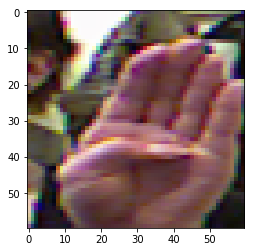

In [42]:
show_picture(1800)

In [84]:
y_other.shape

(565,)

In [97]:
X_all = np.vstack((X_p, X_p_test, X_other_p))
y_all_cat = np.vstack((y_cat, y_cat_test, y_cat_other))

In [98]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X_all, y_all_cat, test_size = 0.2)

In [51]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

In [55]:
y_cat = np_utils.to_categorical([3 if y_o == 'v' else ord(y_o) - ord('a') for y_o in y], 4)
y_cat_test = np_utils.to_categorical([3 if y_o == 'v' else ord(y_o) - ord('a') for y_o in y_test], 4)
y_cat_other = np_utils.to_categorical([3 if y_o == 'v' else ord(y_o) - ord('a') for y_o in y_other], 4)

In [188]:
model = Sequential()
#Добавляем уровни сети
model.add(Dense(200, input_dim=size*size*3, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='softmax'))
#Компилируем модель
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 200)               2160200   
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 804       
Total params: 2,161,004
Trainable params: 2,161,004
Non-trainable params: 0
_________________________________________________________________
None


In [189]:
model.fit(X1, y1, batch_size=300, epochs=30, verbose=True, validation_split=0.1, shuffle=True)

Train on 2322 samples, validate on 258 samples
Epoch 1/30
2322/2322 [==============================] - 1s - loss: 1.6325 - acc: 0.2976 - val_loss: 1.3407 - val_acc: 0.3682
Epoch 2/30
2322/2322 [==============================] - 0s - loss: 1.3225 - acc: 0.4190 - val_loss: 1.1840 - val_acc: 0.4380

In [178]:
scores = model.evaluate(X2, y2, verbose=True)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1] * 100))

544/646 [========================>.....] - ETA: 0sТочность работы на тестовых данных: 77.86%


In [180]:
im_ilya_a = plt.imread('222.jpg')
im_ilya_a_resize = resize_picture(im_ilya_a, (size, size, 3))
model.predict(im_ilya_a_resize.reshape(size*size*3).reshape(1, 10800))

array([[ 0.15622784,  0.32895967,  0.08882753,  0.42598495]], dtype=float32)

In [73]:
%%time
#Обучаем сеть
model.fit(X_p, y_cat, batch_size=300, epochs=25, verbose=True, validation_split=0.1, shuffle=True)

Train on 2066 samples, validate on 230 samples
Epoch 1/25
2066/2066 [==============================] - 2s - loss: 0.1542 - acc: 0.9632 - val_loss: 0.9196 - val_acc: 0.6870
Epoch 2/25
2066/2066 [==============================] - 2s - loss: 0.1515 - acc: 0.9647 - val_loss: 0.7839 - val_acc: 0.7087

In [181]:
scores = model.evaluate(X_p_test, y_cat_test, verbose=True)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1] * 100))

scores = model.evaluate(X_other_p, y_cat_other, verbose=True)
print("Точность работы на других данных: %.2f%%" % (scores[1] * 100))

512/565 [==========================>...] - ETA: 0sТочность работы на других данных: 56.28%


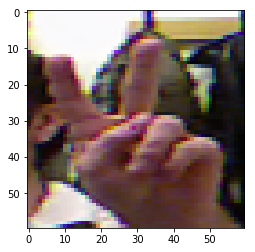

In [161]:
plt.imshow(X1[1000].reshape((60, 60, 3)))

## Новая модель

In [191]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [196]:
model = Sequential()
#Первый свёрточный слой
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(60, 60, 3), activation='relu'))
#Второй свёрточный слой
model.add(Conv2D(32, (3, 3), activation='relu'))
#Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации
model.add(Dropout(0.25))
#Третий свёрточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Четвёртый свёрточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
#Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации
model.add(Dropout(0.25))
#Преобразование из двумерного вида в плоский
model.add(Flatten())
#Полносвязный слой
model.add(Dense(512, activation='relu'))
#Слой регуляризации
model.add(Dropout(0.5))
#Выходной слой
model.add(Dense(4, activation='softmax'))

In [197]:
#Компилируем сеть
model.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

In [198]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

In [212]:
model.fit(X1.reshape(X1.shape[0], 60, 60, 3), y1, batch_size=100, epochs=20, validation_split=0.1, shuffle=True, verbose=True)

Train on 2322 samples, validate on 258 samples
Epoch 1/20
2322/2322 [==============================] - 49s - loss: 1.0850 - acc: 0.5642 - val_loss: 1.0159 - val_acc: 0.6240

In [213]:
scores = model.evaluate(X_test, y_cat_test, verbose=True)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1] * 100))

scores = model.evaluate(X_other, y_cat_other, verbose=True)
print("Точность работы на других данных: %.2f%%" % (scores[1] * 100))

365/365 [==============================] - 2s     
Точность работы на тестовых данных: 90.96%
565/565 [==============================] - 3s     

b (60, 60, 3)


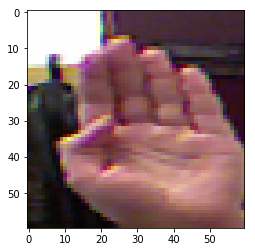

In [219]:
show_picture(920)

In [217]:
im_ilya_a = plt.imread('b1.jpg')
im_ilya_a_resize = resize_picture(im_ilya_a, (size, size, 3))
model.predict(im_ilya_a_resize.reshape(1, 60, 60, 3))

array([[ 0.12128229,  0.05861808,  0.14806773,  0.67203188]], dtype=float32)

In [220]:
model.predict(X[920].reshape(1, 60, 60, 3))

array([[ 0.0018069 ,  0.9932667 ,  0.0027032 ,  0.00222317]], dtype=float32)